In [1]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2

import os
import timm
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score
import time
import import_ipynb
#from data_undersampling import undersampling1
from data_oversampling import *
device = torch.device('cuda')

importing Jupyter notebook from data_oversampling.ipynb


In [2]:
train_png = sorted(glob('data/train/*.png'))
test_png = sorted(glob('data/test/*.png'))

Counter({'hazelnut-good': 391, 'screw-good': 320, 'carpet-good': 280, 'pill-good': 267, 'grid-good': 264, 'wood-good': 247, 'leather-good': 245, 'zipper-good': 240, 'tile-good': 230, 'cable-good': 224, 'metal_nut-good': 220, 'capsule-good': 219, 'transistor-good': 213, 'bottle-good': 209, 'toothbrush-good': 60, 'toothbrush-defective': 15, 'pill-crack': 13, 'pill-color': 13, 'screw-scratch_neck': 13, 'metal_nut-bent': 13, 'metal_nut-scratch': 12, 'screw-thread_side': 12, 'pill-scratch': 12, 'screw-manipulated_front': 12, 'screw-thread_top': 12, 'capsule-crack': 12, 'metal_nut-flip': 12, 'screw-scratch_head': 12, 'capsule-scratch': 12, 'bottle-contamination': 11, 'capsule-poke': 11, 'metal_nut-color': 11, 'bottle-broken_small': 11, 'pill-contamination': 11, 'wood-scratch': 11, 'capsule-faulty_imprint': 11, 'capsule-squeeze': 10, 'bottle-broken_large': 10, 'leather-cut': 10, 'carpet-thread': 10, 'pill-faulty_imprint': 10, 'leather-glue': 10, 'carpet-color': 10, 'zipper-broken_teeth': 10, 

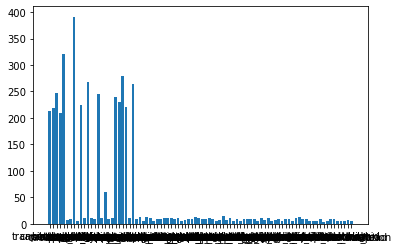

Counter({'transistor-good': 391, 'capsule-good': 391, 'wood-good': 391, 'bottle-good': 391, 'screw-good': 391, 'cable-bent_wire': 391, 'carpet-hole': 391, 'hazelnut-good': 391, 'pill-pill_type': 391, 'cable-good': 391, 'metal_nut-scratch': 391, 'pill-good': 391, 'screw-thread_side': 391, 'zipper-fabric_border': 391, 'leather-good': 391, 'pill-scratch': 391, 'toothbrush-good': 391, 'hazelnut-crack': 391, 'screw-manipulated_front': 391, 'zipper-good': 391, 'tile-good': 391, 'carpet-good': 391, 'metal_nut-good': 391, 'bottle-contamination': 391, 'grid-good': 391, 'zipper-split_teeth': 391, 'pill-crack': 391, 'wood-combined': 391, 'pill-color': 391, 'screw-thread_top': 391, 'cable-missing_cable': 391, 'capsule-squeeze': 391, 'zipper-rough': 391, 'capsule-crack': 391, 'capsule-poke': 391, 'metal_nut-flip': 391, 'carpet-metal_contamination': 391, 'metal_nut-color': 391, 'transistor-bent_lead': 391, 'zipper-fabric_interior': 391, 'leather-fold': 391, 'tile-glue_strip': 391, 'screw-scratch_nec

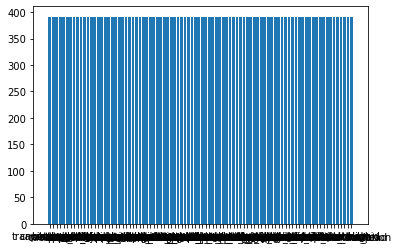

In [3]:
#train_y = pd.read_csv("data/train_df.csv")

# SMOTE oversampling  사용
overdata = smote_oversampling("./data/train_df.csv")
y = overdata[1]

train_labels = y

label_unique = sorted(np.unique(train_labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

train_labels = [label_unique[k] for k in train_labels]


In [4]:
# train, test 이미지 리사이즈
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (512, 512))
    return img


In [6]:
train_imgs = [img_load(m) for m in tqdm(train_png)]
test_imgs = [img_load(n) for n in tqdm(test_png)]


 10%|████████                                                                       | 437/4277 [00:07<01:06, 57.61it/s]


 21%|████████████████▍                                                              | 893/4277 [00:14<01:00, 55.74it/s]


 31%|████████████████████████▎                                                     | 1335/4277 [00:22<00:46, 63.65it/s]


 41%|████████████████████████████████▎                                             | 1774/4277 [00:29<00:41, 59.90it/s]


 52%|████████████████████████████████████████▍                                     | 2216/4277 [00:37<00:36, 56.21it/s]


 62%|████████████████████████████████████████████████▏                             | 2642/4277 [00:44<00:28, 58.23it/s]


 72%|███████████████████████████████████████████████████████▉                      | 3066/4277 [00:52<00:20, 60.20it/s]


 82%|███████████████████████████████████████████████████████████████▉              | 3504/4277 [00:59<00:12, 60.66it/s]


 92%|███████████████████████████████████████████████████████████████████████▊      | 3939/4277 [01:07<00:05, 60.10it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4277/4277 [01:12<00:00, 58.69it/s]

  5%|███▋                                                                            | 98/2154 [00:01<00:34, 59.24it/s]


 26%|████████████████████▎                                                          | 555/2154 [00:09<00:26, 60.33it/s]


 46%|████████████████████████████████████▏                                         | 1001/2154 [00:16<00:19, 60.41it/s]


 68%|████████████████████████████████████████████████████▊                         | 1457/2154 [00:24<00:11, 59.91it/s]


 88%|████████████████████████████████████████████████████████████████████▉         | 1904/2154 [00:31<00:04, 58.12it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 2154/2154 [00:35<00:00, 60.46it/s]


In [7]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode=='train':
            augmentation = random.randint(0,2)
            if augmentation==1:
                img = img[::-1].copy()
            elif augmentation==2:
                img = img[:,::-1].copy()
        img = transforms.ToTensor()(img)
        if self.mode=='test':
            pass
        
        label = self.labels[idx]
        return img, label
    
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=88)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [8]:
batch_size = 32
epochs = 25

# Train
train_dataset = Custom_dataset(np.array(train_imgs), np.array(train_labels), mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

# Test
test_dataset = Custom_dataset(np.array(test_imgs), np.array(["tmp"]*len(test_imgs)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [9]:
def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

model = Network().to(device)

# 최적화
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-3)
# 손실함수
criterion = nn.CrossEntropyLoss()
# 특성별로 데이터 스케일이 다를 경우, 모든 특성의 범위를 갖게 만들어줌 
scaler = torch.cuda.amp.GradScaler() 



best=0
for epoch in range(epochs):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model.train()
    for batch in (train_loader):
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
        
    
    train_f1 = score_function(train_y, train_pred)

    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b4_ra2_320-7eb33cd5.pth" to C:\Users\user/.cache\torch\hub\checkpoints\efficientnet_b4_ra2_320-7eb33cd5.pth


epoch : 1/25    time : 76s/1820s
TRAIN    loss : 0.86348    f1 : 0.29992
epoch : 2/25    time : 74s/1698s
TRAIN    loss : 0.31613    f1 : 0.56808
epoch : 3/25    time : 74s/1632s
TRAIN    loss : 0.17741    f1 : 0.76074
epoch : 4/25    time : 75s/1570s
TRAIN    loss : 0.16804    f1 : 0.79886
epoch : 5/25    time : 72s/1448s
TRAIN    loss : 0.11010    f1 : 0.85156
epoch : 6/25    time : 73s/1393s
TRAIN    loss : 0.10735    f1 : 0.88225
epoch : 7/25    time : 73s/1305s
TRAIN    loss : 0.07423    f1 : 0.89308
epoch : 8/25    time : 73s/1238s
TRAIN    loss : 0.05189    f1 : 0.94369
epoch : 9/25    time : 72s/1155s
TRAIN    loss : 0.05586    f1 : 0.94335
epoch : 10/25    time : 72s/1083s
TRAIN    loss : 0.05262    f1 : 0.95454
epoch : 11/25    time : 72s/1002s
TRAIN    loss : 0.03565    f1 : 0.97166
epoch : 12/25    time : 72s/932s
TRAIN    loss : 0.06027    f1 : 0.93638
epoch : 13/25    time : 71s/856s
TRAIN    loss : 0.05872    f1 : 0.93078
epoch : 14/25    time : 74s/813s
TRAIN    loss : 

In [10]:
model.eval()
f_pred = []

with torch.no_grad():
    for batch in (test_loader):
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

In [11]:
label_decoder = {val:key for key, val in label_unique.items()}

f_result = [label_decoder[result] for result in f_pred]

In [12]:
submission = pd.read_csv("data/sample_submission.csv")

submission["label"] = f_result

submission

,index,label
0,0,tile-glue_strip
1,1,grid-good
2,2,transistor-misplaced
3,3,tile-gray_stroke
4,4,tile-good
...,...,...
2149,2149,tile-gray_stroke
2150,2150,screw-good
2151,2151,grid-good
2152,2152,cable-good


In [13]:
submission.to_csv("efficientnet_b4_smote-oversampling.csv", index = False)